In [1]:
import numpy as np
import matplotlib.pyplot as plt
from floweaver import *
from modules.algorithms import UtilityMatrix
from modules.agents import Population
from modules.simulator import Simulator
from modules.rewardsFunctions import RewardFunctionExponential, RewardFunctionSquaredExponential
from modules.samplers import UniformSamplerRecommendation, GaussianSamplerRecommendation, MixtureGaussianSamplerRecommendation
from modules.samplers import UniformSamplerOpinion, GaussianSamplerOpinion, MixtureGaussianSamplerOpinion
from modules.parameters import ParametersUser, ParametersPopulation
from modules.basic import Opinion

In [2]:
reward = RewardFunctionSquaredExponential(decay_parameter=1.0)
# recommendation_sampler = UniformSamplerRecommendation(low=-1.0, high=1.0)
# recommendation_sampler = MixtureGaussianSamplerRecommendation(mean=[-1.0, 1.0], std=[0.1, 0.1])
recommendation_sampler = GaussianSamplerRecommendation(mean=0.0, std=0.5)
opinion_sampler = UniformSamplerOpinion(low=0.0*(-2.0), high=2.0)

In [3]:
weight_prejudice = 0.1
save_plots = False
n_f, n_b = 21, 20
f_vec = np.hstack([np.arange(1, 15, 1), np.arange(17, 23, 1), np.arange(26, 46, 1), np.array([51])]) #np.linspace(start=1, stop=21, num=n_f)
n_f = f_vec.size
b_vec = np.linspace(start=0, stop=1-weight_prejudice, num=n_b)

f_mat, b_mat  = np.meshgrid(f_vec, b_vec, indexing='ij')

d_initial_opinion, c_initial_opinion, d_initial_recommendation, c_initial_recommendation, w_initial_opinion, w_initial_recommendation, w_convergence_distribution \
    = np.zeros((n_f, n_b)),  np.zeros((n_f, n_b)), np.zeros((n_f, n_b)),  np.zeros((n_f, n_b)), np.zeros((n_f, n_b)),  np.zeros((n_f, n_b)), np.zeros((n_f, n_b))
final_distribution = []

for i in range(n_f):
    print(i)
    final_distribution_i = []
    for j in range(n_b):
        parameters = ParametersUser(prejudice=0.0,
                                    weight_prejudice=weight_prejudice,
                                    weight_recommendation=1-weight_prejudice-b_mat[i, j],
                                    weight_current_opinion=b_mat[i, j],
                                    reward=reward)
        parameters_population = ParametersPopulation(parameters=parameters,
                                                     prejudice_sampler=opinion_sampler,
                                                     repeat=5000)
        # Define population
        population = Population(parameters=parameters_population,
                                initial_state=None,
                                initialize_with_prejudice=True,
                                save_history=False)

        alg = UtilityMatrix(n_agents=population.n_agents(),
                            recommendation_sampler=recommendation_sampler,
                            exploration_probability=None,
                            exploration_frequency=f_mat[i, j],
                            save_history=False)
        # Simulator
        simulator = Simulator(agent=population,
                              algorithm=alg)
        # Run
        simulator.run(horizon=50, #int(20*f_mat[i, j]),  # TODO: do exploration cycles
                      initialize_with_prejudice=True,
                      initialize=False)
        # Metrics
        d = simulator.metrics()
        d_initial_opinion[i, j] = d['distance_initial_opinion']
        d_initial_recommendation[i, j] = d['distance_initial_recommendation']
        c_initial_opinion[i, j] = d['close_initial_opinion']
        c_initial_recommendation[i, j] = d['close_initial_recommendation']
        w_initial_opinion[i, j] = d['wasserstein_distance_initial_opinion']
        w_initial_recommendation[i, j] = d['wasserstein_distance_initial_recommendation']
        w_convergence_distribution[i, j] = d['wasserstein_distance_predicted_convergence']
        final_distribution_i.append([]) # d['final_distribution'])
    final_distribution.append(final_distribution_i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


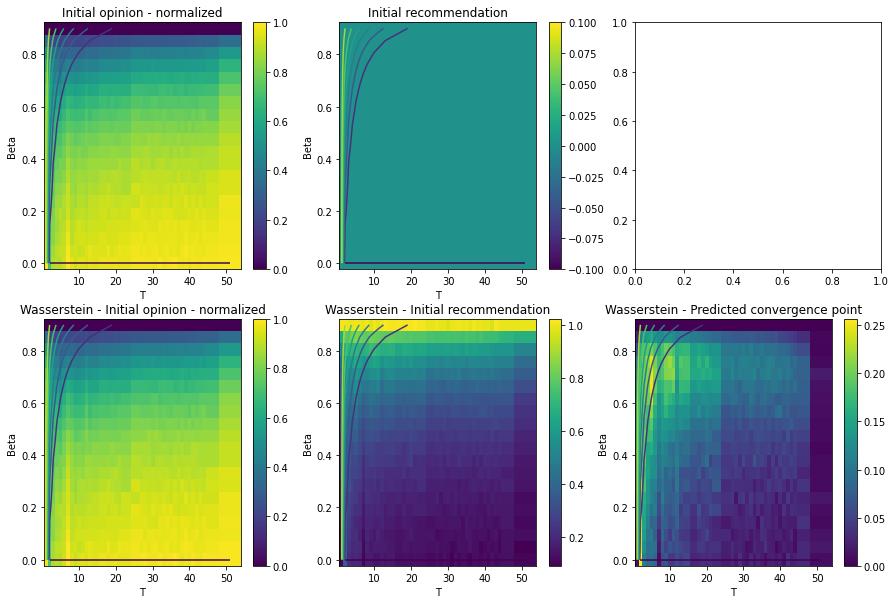

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]

save_plots = True

d_initial_opinion /= d_initial_opinion.max()
# d_initial_recommendation /= d_initial_recommendation.max()
w_initial_opinion /= w_initial_opinion.max()
# w_initial_recommendation /= w_initial_recommendation.max()

# Make plot  # TODO: distance caused by random recommender system
fig, axes = plt.subplots(nrows=2, ncols=3)

ax = axes[0, 0]
c = ax.pcolormesh(f_mat, b_mat, d_initial_opinion)
ax.contour(f_mat, b_mat, np.power(b_mat, f_mat-1))
fig.colorbar(c, ax=ax)
ax.set_title('Initial opinion - normalized')
ax.set_ylabel('Beta')
ax.set_xlabel('T')
if save_plots:
    np.savetxt("d_micro_alpha="+str(weight_prejudice)+".csv", np.vstack((f_mat.reshape(-1), b_mat.reshape(-1), d_initial_opinion.reshape(-1))).T, delimiter=",")

ax = axes[0, 1]
c = ax.pcolormesh(f_mat, b_mat, d_initial_recommendation)
ax.contour(f_mat, b_mat, np.power(b_mat, f_mat-1))
fig.colorbar(c, ax=ax)
ax.set_title('Initial recommendation')
ax.set_ylabel('Beta')
ax.set_xlabel('T')

ax = axes[1, 0]
c = ax.pcolormesh(f_mat, b_mat, w_initial_opinion)
ax.contour(f_mat, b_mat, np.power(b_mat, f_mat-1))
fig.colorbar(c, ax=ax)
ax.set_title('Wasserstein - Initial opinion - normalized')
ax.set_ylabel('Beta')
ax.set_xlabel('T')
if save_plots:
    np.savetxt("d_macro_alpha="+str(weight_prejudice)+".csv", np.vstack((f_mat.reshape(-1), b_mat.reshape(-1), w_initial_opinion.reshape(-1))).T, delimiter=",")

ax = axes[1, 1]
c = ax.pcolormesh(f_mat, b_mat, w_initial_recommendation)
ax.contour(f_mat, b_mat, np.power(b_mat, f_mat-1))
fig.colorbar(c, ax=ax)
ax.set_title('Wasserstein - Initial recommendation')
ax.set_ylabel('Beta')
ax.set_xlabel('T')
if save_plots:
    np.savetxt("d_rec_alpha="+str(weight_prejudice)+".csv", np.vstack((f_mat.reshape(-1), b_mat.reshape(-1), w_initial_recommendation.reshape(-1))).T, delimiter=",")

ax = axes[1, 2]
c = ax.pcolormesh(f_mat, b_mat, w_convergence_distribution)
ax.contour(f_mat, b_mat, np.power(b_mat, f_mat-1))
fig.colorbar(c, ax=ax)
ax.set_title('Wasserstein - Predicted convergence point')
ax.set_ylabel('Beta')
ax.set_xlabel('T')
if save_plots:
    np.savetxt("d_macro_conv_alpha="+str(weight_prejudice)+".csv", np.vstack((f_mat.reshape(-1), b_mat.reshape(-1), w_convergence_distribution.reshape(-1))).T, delimiter=",")

plt.show()

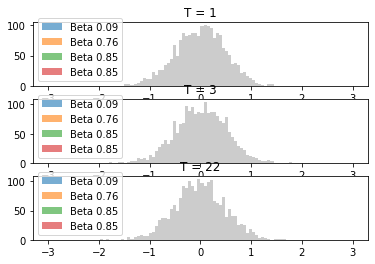

In [5]:
# TODO: do plot for fixed T and various beta (each beta a color and a histogram)
fig, axes = plt.subplots(3, 1)

idx_f_plot = [0, 2, 19]
idx_beta_plot = [int(0.1*n_b), int(0.8*n_b), int(0.9*n_b), n_b-2]

for i_ax, i in enumerate(idx_f_plot):
    ax = axes[i_ax]
    ax.hist(x=recommendation_sampler.sample(number=2000), bins=100, range=(-3,3), alpha=0.2, color='black')
    for j in idx_beta_plot:
        ax.hist(final_distribution[i][j],
                bins=100, range=(-3,3), alpha=0.6,
                label='Beta ' + str(np.round(b_vec[j], 2)))
    ax.legend()
    ax.set_title('T = ' + str(f_vec[i]))

plt.show()

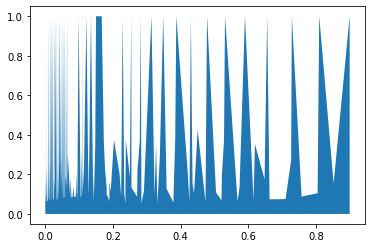

In [6]:
# Make plot histogram
fig, ax = plt.subplots(1, 1)

x_plot = np.power(b_mat, f_mat).reshape(-1)

idx = np.argsort(x_plot)
x_plot = x_plot[idx]
y_plot_1 = c_initial_opinion.reshape(-1)[idx]
y_plot_2 = c_initial_recommendation.reshape(-1)[idx]

ax.fill_between(x_plot, y_plot_1)
ax.fill_between(x_plot, y_plot_1+y_plot_2, y_plot_1)
# ax.scatter(x_plot, y_plot_1)
# ax.scatter(x_plot, y_plot_2+y_plot_1)

plt.show()